## Test of using VO to download data


Set up the imports.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import requests, io, astropy
from IPython.display import Image, display, HTML
import html
import seaborn as sns

## For handling ordinary astropy Tables
from astropy.table import Table

## For reading FITS files
from astropy.io import fits

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

Faster way of downloading files (hopefully)

In [3]:
from urllib.request import urlretrieve

This seems to be a simpler approach than using `requests`, where we would have to mess about with chunking and the like.  See [SO answer](https://stackoverflow.com/a/44378512/353062)

Example usage:
``` python
url = 'http://mirror.pnl.gov/releases/16.04.2/ubuntu-16.04.2-desktop-amd64.iso'
dst = 'ubuntu-16.04.2-desktop-amd64.iso'
urlretrieve(url, dst)
```

### Getting images from SkyView

This based on an [example from the AAS Workshop 2018](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Image_Access.ipynb)

We will start with LP Ori and try and get images from SkyView

#### First, use Table Access Protocol to find resources that support Simple Image Access

In [4]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,b.res_description, c.access_url 
        from rr.capability a natural join rr.resource b natural join rr.interface c
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
## The astropy.table  module will read this VO Table formatted result into an astropy Table:
cat_table=Table.read(io.BytesIO(r.content))
#print(r.content)
## Just look at some non-so-randomly selected rows out of the 108 returned:
cat_table[85:96]
## Note that some of the other rows have special characters that confuse the print functions and cause errors.

short_name,res_description,access_url
object,object,object
SDSS,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive (currently release DR9) to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdss&amp;
SDSSDR7,The Sloan Digital Sky Survey is the deepest large scale survey of the sky currently available. SkyView dynamically queries the SDSS archive to retrieve information and resample it into the user requested frame. Further information on the SDSS and many additional services are available at the &amp;lt;a href=http://www.sdss.org&amp;gt; SDSS Web site&amp;lt;/a&amp;gt;.,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sdssdr7&amp;
SFD,"The full sky 100 micron map is a reprocessed composite of the COBE/DIRBE and IRAS/ISSA maps, with the zodiacal foreground and confirmed point sources removed. Artifacts from the IRAS scan pattern were removed. The result of these manipulations is a map with DIRBE-quality calibration and IR AS resolution.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=sfd&amp;
SHASSA,"The Sshassa\.xml\.outhern H-Alpha Sky Survey Atlas is the product of a wide-angle digital imaging survey of the H-alpha emission from the warm ionized interstellar gas of our Galaxy. This atlas covers the sshassa\.xml\.outhern hemisphere sky (declinations less than +15 degrees). The observations were taken with a robotic camera operating at Cerro Tololo Inter-American Observatory (CTIO) in Chile. The atlas consists of 2168 images covering 542 fields. There are four images available for each field: &amp;lt;b&amp;gt;H-alpha&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum&amp;lt;/b&amp;gt;, &amp;lt;b&amp;gt;Continuum-Corrected&amp;lt;/b&amp;gt; (the difference of the H-alpha and Continuum images), and &amp;lt;b&amp;gt;Smoothed&amp;lt;/b&amp;gt; (median filtered to 5 pixel, or 4.0 arcminute, resolution to remove star residuals better). The &amp;lt;a href=""http://amundsen.swarthmore.edu/SHASSA""&amp;gt;SHASSA web site&amp;lt;/a&amp;gt; has more details of the data and the status of this and related projects. Images can also be obtained from the &amp;lt;a href=""http://amundsen.astro.swarthmore.edu/SHASSA/#Images""&amp;gt;Download Images&amp;lt;/a&amp;gt; section at the SHASSA site.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=shassa&amp;
SkyView,"SkyView is a Virtual Observatory on the Net. Astronomers can generate images of any portion of the sky at wavelengths in all regimes from radio to gamma-ray. Users tell SkyView the position, scale and orientation desired, and SkyView gives users an image made to their specification. The user need not worry about transforming between equinoxes or coordinate systesm, mosaicking submaps, rotating the image,.... SkyView handles these geometric issues and lets the user get started on astronomy.",https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?
Stripe82VLA,"This survey is a deep, high resolution radio survey of a relatively small region that has particularly deep coverage in the Sloan Digital Sky Survey. As described in the reference abstract: This is a high-resolution radio survey of the Sloan Digital Sky Survey (SDSS) Southern Equatorial Stripe, a.k.a., Stripe 82. This 1.4 GHz survey was conducted from 2007 to 2009 with the Very Large Array primarily in the A-configuration, with supplemental B-configuration data to increase sensitivity to extended structure. The survey has an angular resolution of 1.8"" and achieves a median rms noise of 53 microJy/beam over 92 square degrees. This is the deepest 1.4 GHz survey to achieve this large of an area filling in the phase space between small&amp;amp;amp;deep and large&amp;amp;amp;shallow surveys. &amp;lt;p&amp;gt; Th

Get a list of all of the resources.  Note that the values in the table are bytes, not strings, so they need to be decoded before we can do much with them.

In [5]:
' '.join(_.decode() for _ in cat_table['short_name'])

'1420MHz 2MASS 408MHz AKARI ASCA ASCA/AGN ASCASIS BAT-flux-1 BATSIG CDFS-LESS CFHTLS-D-u CFHTLS-W-u Chandra CO COBE Comptel DSS DSS1B DSS1R DSS2 EBHIS EGRET EGRET3D EUVE FERMI FIRST GALEX GalexFar GalexNear GNS GOODS-ACS GOODS-ACS B GOODS-ISAAC GOODS-ISAAC H GOODS-VIMOS GOODS-VIMOS R GOODSACISB GOODSACISFB GOODSHerschel1 GOODSHerschel2 GOODSHerschel3 GOODSHerschel4 GOODSHerschel5 GOODSIRAC GOODSIRAC-1 GOODSMIPS GOODSNVLA GRANAT GTEE HAlpha Hawaii-HDF Hawaii-HDF B HEAO1A HERSCHEL-SPIRE HI4PI HRI HUDFISAAC INTEGRALSPI_gc INTGAL INTGAL1735E IRAS IRIS MELLINGER NEAT nH NUMASTER NVSS Planck Planck030 PMN PSPC0.6Int PSPC1 PSPC2 PSPC6 RASS3 RASSALL RASSBACK RASSBCK RASSMASTER ROSAT ROSAT/HRI ROSAT/HRI ROSAT/PSPC RXTE RXTE3_20k_flux SDSS SDSSDR7 SFD SHASSA SkyView Stripe82VLA SUMSS SUZAMASTER SwiftBAT SwiftUVOT SWIFTUVOT SWIFTXRT SwiftXRT TGSS UKIDSS UltraVista-H VLSS WENSS WFCF WFCF1 WISE WMAP XMM'

Same thing, but using `map` instead of a comprehension:

In [6]:
' '.join(map(bytes.decode, cat_table['short_name']))

'1420MHz 2MASS 408MHz AKARI ASCA ASCA/AGN ASCASIS BAT-flux-1 BATSIG CDFS-LESS CFHTLS-D-u CFHTLS-W-u Chandra CO COBE Comptel DSS DSS1B DSS1R DSS2 EBHIS EGRET EGRET3D EUVE FERMI FIRST GALEX GalexFar GalexNear GNS GOODS-ACS GOODS-ACS B GOODS-ISAAC GOODS-ISAAC H GOODS-VIMOS GOODS-VIMOS R GOODSACISB GOODSACISFB GOODSHerschel1 GOODSHerschel2 GOODSHerschel3 GOODSHerschel4 GOODSHerschel5 GOODSIRAC GOODSIRAC-1 GOODSMIPS GOODSNVLA GRANAT GTEE HAlpha Hawaii-HDF Hawaii-HDF B HEAO1A HERSCHEL-SPIRE HI4PI HRI HUDFISAAC INTEGRALSPI_gc INTGAL INTGAL1735E IRAS IRIS MELLINGER NEAT nH NUMASTER NVSS Planck Planck030 PMN PSPC0.6Int PSPC1 PSPC2 PSPC6 RASS3 RASSALL RASSBACK RASSBCK RASSMASTER ROSAT ROSAT/HRI ROSAT/HRI ROSAT/PSPC RXTE RXTE3_20k_flux SDSS SDSSDR7 SFD SHASSA SkyView Stripe82VLA SUMSS SUZAMASTER SwiftBAT SwiftUVOT SWIFTUVOT SWIFTXRT SwiftXRT TGSS UKIDSS UltraVista-H VLSS WENSS WFCF WFCF1 WISE WMAP XMM'

#### Go for the 2MASS JHK images first 

In [7]:
row = cat_table[cat_table['short_name'] == '2MASS'.encode()]
description = row[0]['res_description'].decode()
url = row[0]['access_url'].decode()
url, description

('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=2mass&amp;',
 '2MASS data were collected by uniformly scanning the entire sky in three near-infrared bands to detect and characterize point sources brighter than ab2mass\\.xml\\.out 1 mJy in each band, with signal-to-noise ratio (SNR) greater than 10, using a pixel size of 2.0". This achieves an 80,000-fold improvement in sensitivity relative to earlier surveys. 2MASS used two new, highly-automated 1.3-m telescopes, one at Mt. Hopkins, AZ, and one at CTIO, Chile. Each telescope is equipped with a three-channel camera, each channel consisting of a 256 by 256 array of HgCdTe detectors, capable of observing the sky simultaneously at J (1.25 microns), H (1.65 microns), and K&amp;lt;sub&amp;gt;s&amp;lt;/sub&amp;gt; (2.17 microns). &amp;lt;p&amp;gt;2MASS images and other data products can be obtained at the &amp;lt;a href="http://irsa.ipac.caltech.edu/applications/2MASS/QL/"&amp;gt;NASA/IPAC Infrared Science Archive&amp;lt;/a&amp;gt;')

In [8]:
display(row[0]['access_url'].decode())

'https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=2mass&amp;'

In [9]:
# This doesn't work for LP Ori - need to find out what Vizier calls it
#import astropy.coordinates as coord
#coord = coord.SkyCoord.from_name("tet01 Ori C")
#pos = '{},{}'.format(coord.ra.deg,coord.dec.deg)
#coord

In [10]:
pos = '83.791114,-5.4649843'
pixel_size = 1.0/3600 # 1 arcsec
size = 0.5
N = int(size/pixel_size)
params = {'POS': pos, 'SIZE': f'{size}', "NAXIS": f"{N},{N}"}
r = requests.get(url, params=params)
twomass_table=Table.read(io.BytesIO(r.content))
twomass_table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
2massh,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massh&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747295985&return=FITS,1
2massh,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massh&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747295985&nofits=1&quicklook=jpeg&return=jpeg,1
2massj,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massj&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747302249&return=FITS,2
2massj,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massj&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747302249&nofits=1&quicklook=jpeg&return=jpeg,2
2massk,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massk&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747306205&return=FITS,3
2massk,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0002777777777777778 0.0002777777777777778],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=2massk&pixels=1800%2C1800&sampler=LI&size=0.5%2C0.5&projection=Tan&coordinates=J2000.0&requestID=skv1539747306205&nofits=1&quicklook=jpeg&return=jpeg,3


In [11]:
rowf = 0
rowj = rowf+1
jpgfile = 'lp_ori_test.jpg'
fitsfile = jpgfile.replace('.jpg', '.fits')

In [12]:
r=requests.get(twomass_table['URL'][rowj].decode("utf-8"), stream=True)
with open(jpgfile,'wb') as f:
    f.write(r.content)

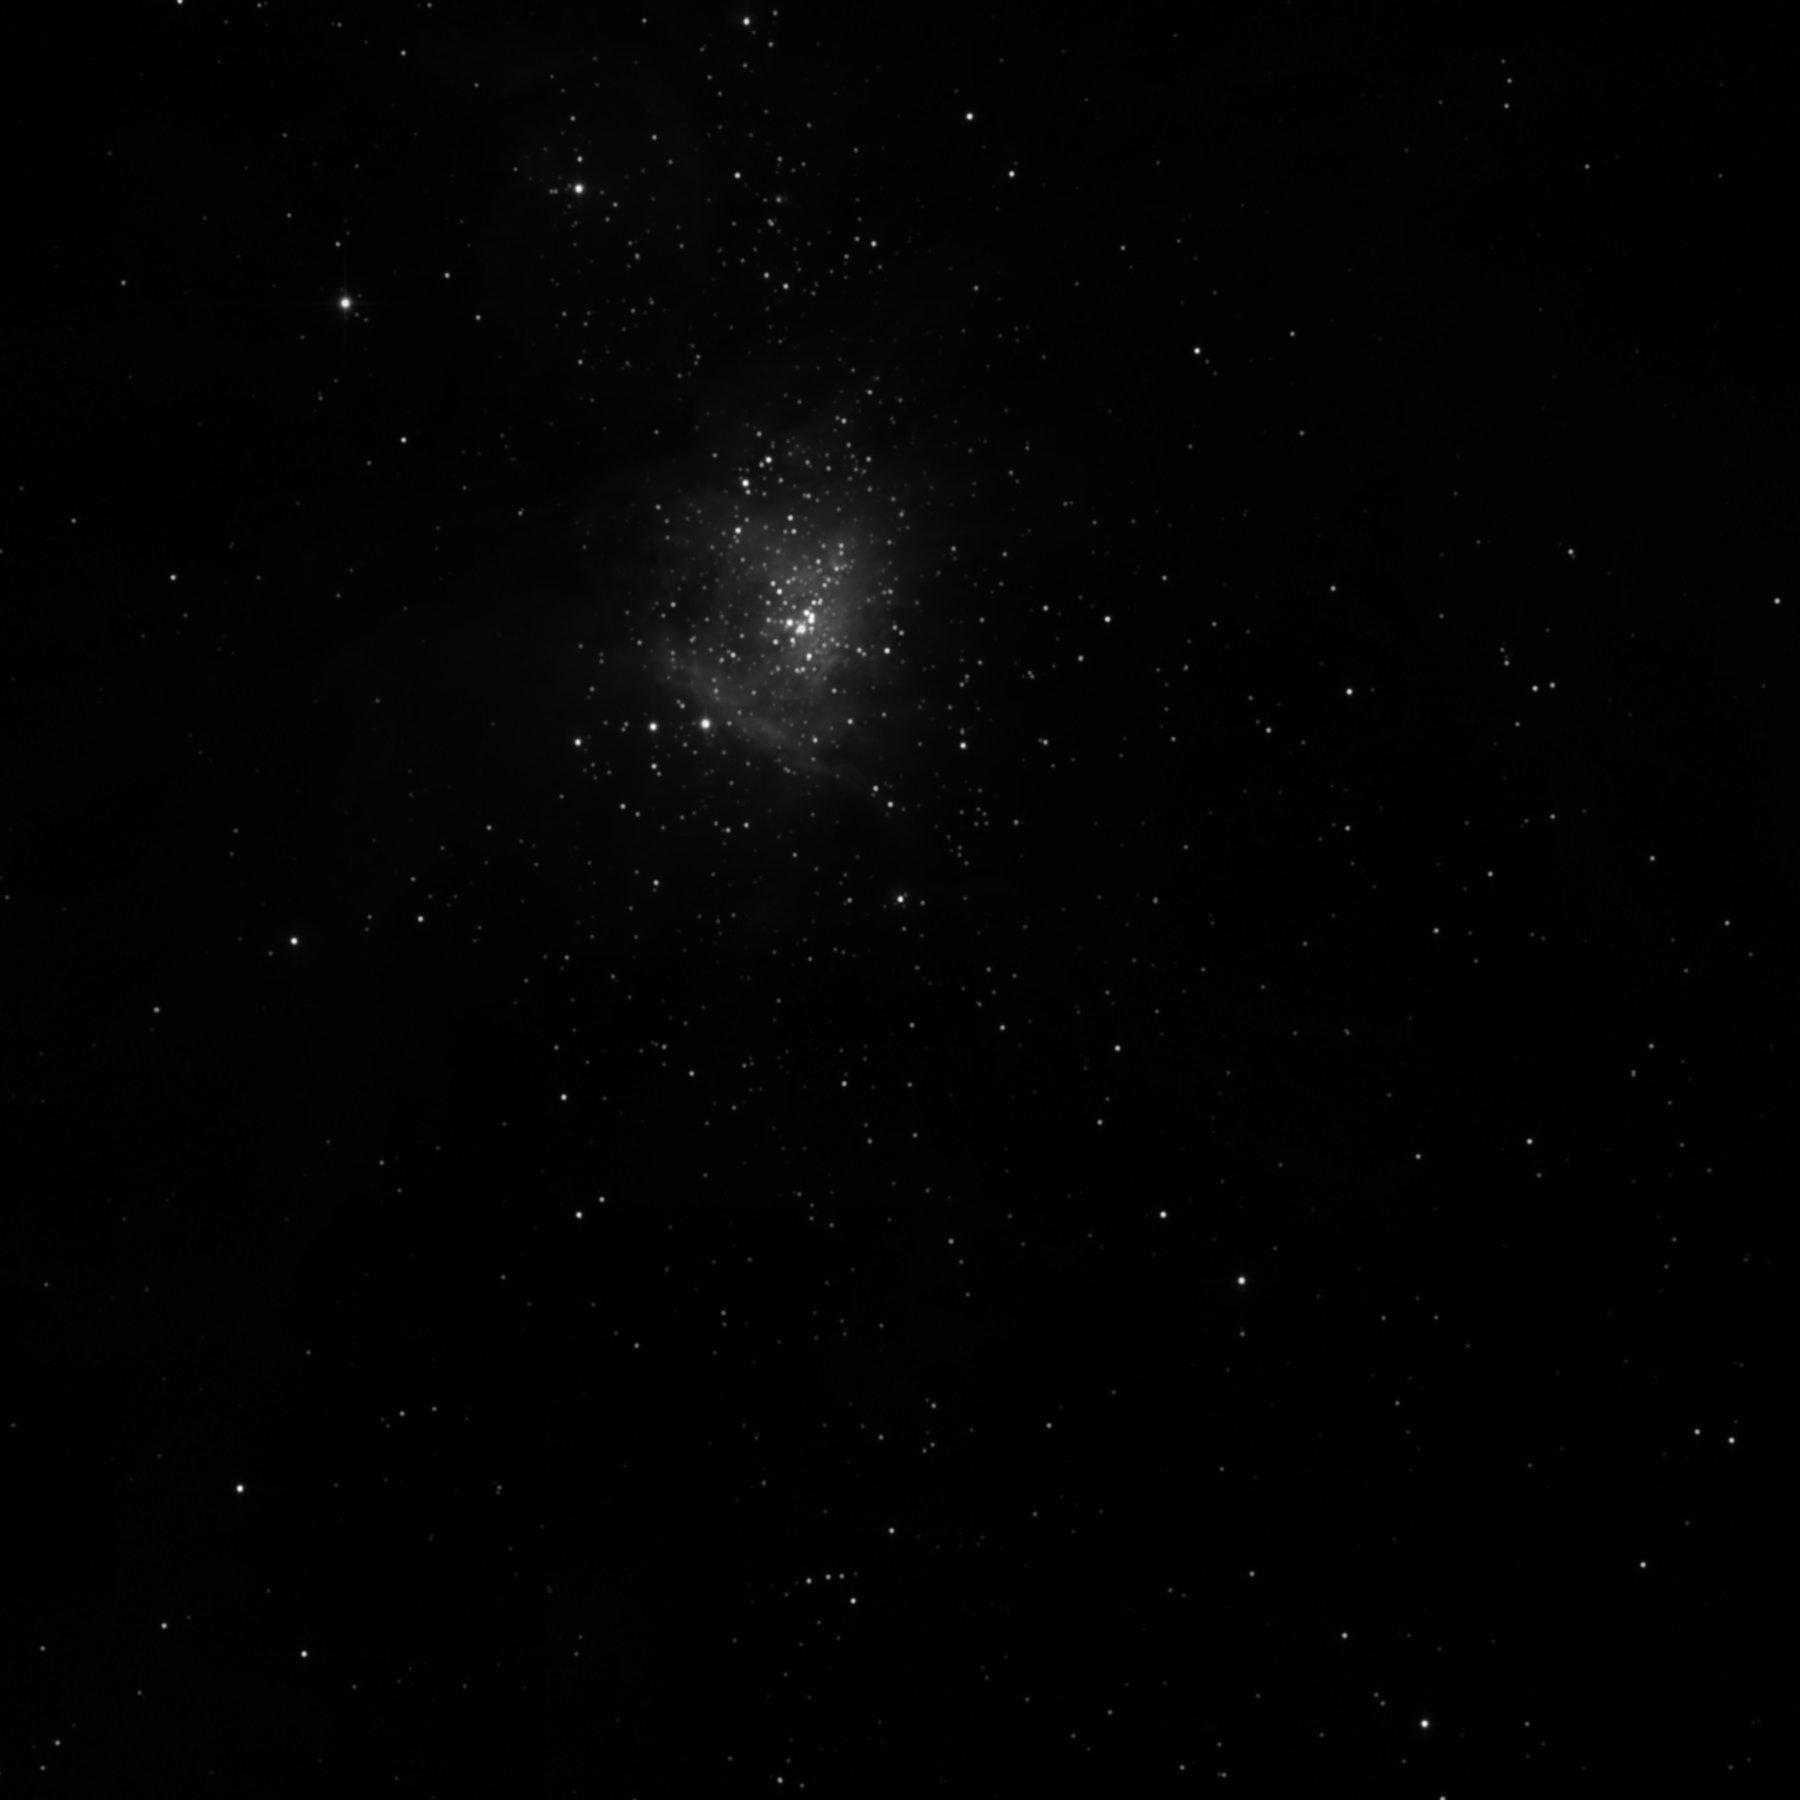

In [13]:
display(Image(jpgfile))

In [14]:
for rowf, band in [0, 'H'], [2, 'J'], [4, 'K']:
    fitsfile = f'lp_ori_2mass_{band}.fits'
    r=requests.get(twomass_table['URL'][rowf].decode("utf-8"), stream=True)
    with open(fitsfile,'wb') as f:
        f.write(r.content)
        fits.open(fitsfile).info()

Filename: lp_ori_2mass_H.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     176   (1800, 1800)   float32   
Filename: lp_ori_2mass_J.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     176   (1800, 1800)   float32   
Filename: lp_ori_2mass_K.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     176   (1800, 1800)   float32   


#### Now try WISE

The description seems to have had HTML entities escaped multiple times, so we use triple-nested `html.unescape` to unwrap all that.

In [15]:
row = cat_table[cat_table['short_name'] == 'WISE'.encode()]
description = row[0]['res_description'].decode('utf-8')
url = row[0]['access_url'].decode()
#display(HTML(description))
description = html.unescape(html.unescape(html.unescape(description)))
text = f'<div style="background-color:#cde;color:#733;padding:20px;">{description}</div>'
display(HTML(text))

In [16]:
pos = '83.791114,-5.4649843'
pixel_size = 2.0/3600 # 2 arcsec
size = 1.0
N = int(size/pixel_size)
params = {'POS': pos, 'SIZE': f'{size}', "NAXIS": f"{N},{N}"}
r = requests.get(url, params=params)
wise_table=Table.read(io.BytesIO(r.content))
wise_table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
wisew1,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew1&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747514351&return=FITS,1
wisew1,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew1&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747514351&nofits=1&quicklook=jpeg&return=jpeg,1
wisew2,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew2&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747517895&return=FITS,2
wisew2,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew2&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747517895&nofits=1&quicklook=jpeg&return=jpeg,2
wisew3,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew3&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747521149&return=FITS,3
wisew3,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew3&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747521149&nofits=1&quicklook=jpeg&return=jpeg,3
wisew4,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew4&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747523111&return=FITS,4
wisew4,83.791113999999993,-5.4649843000000002,2,[1800 1800],[-0.0005555555555555556 0.0005555555555555556],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=wisew4&pixels=1800%2C1800&sampler=LI&size=1.0%2C1.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747523111&nofits=1&quicklook=jpeg&return=jpeg,4


In [17]:
r = requests.get(wise_table['URL'][1].decode("utf-8"), stream=True)
with open(jpgfile,'wb') as f:
    f.write(r.content)

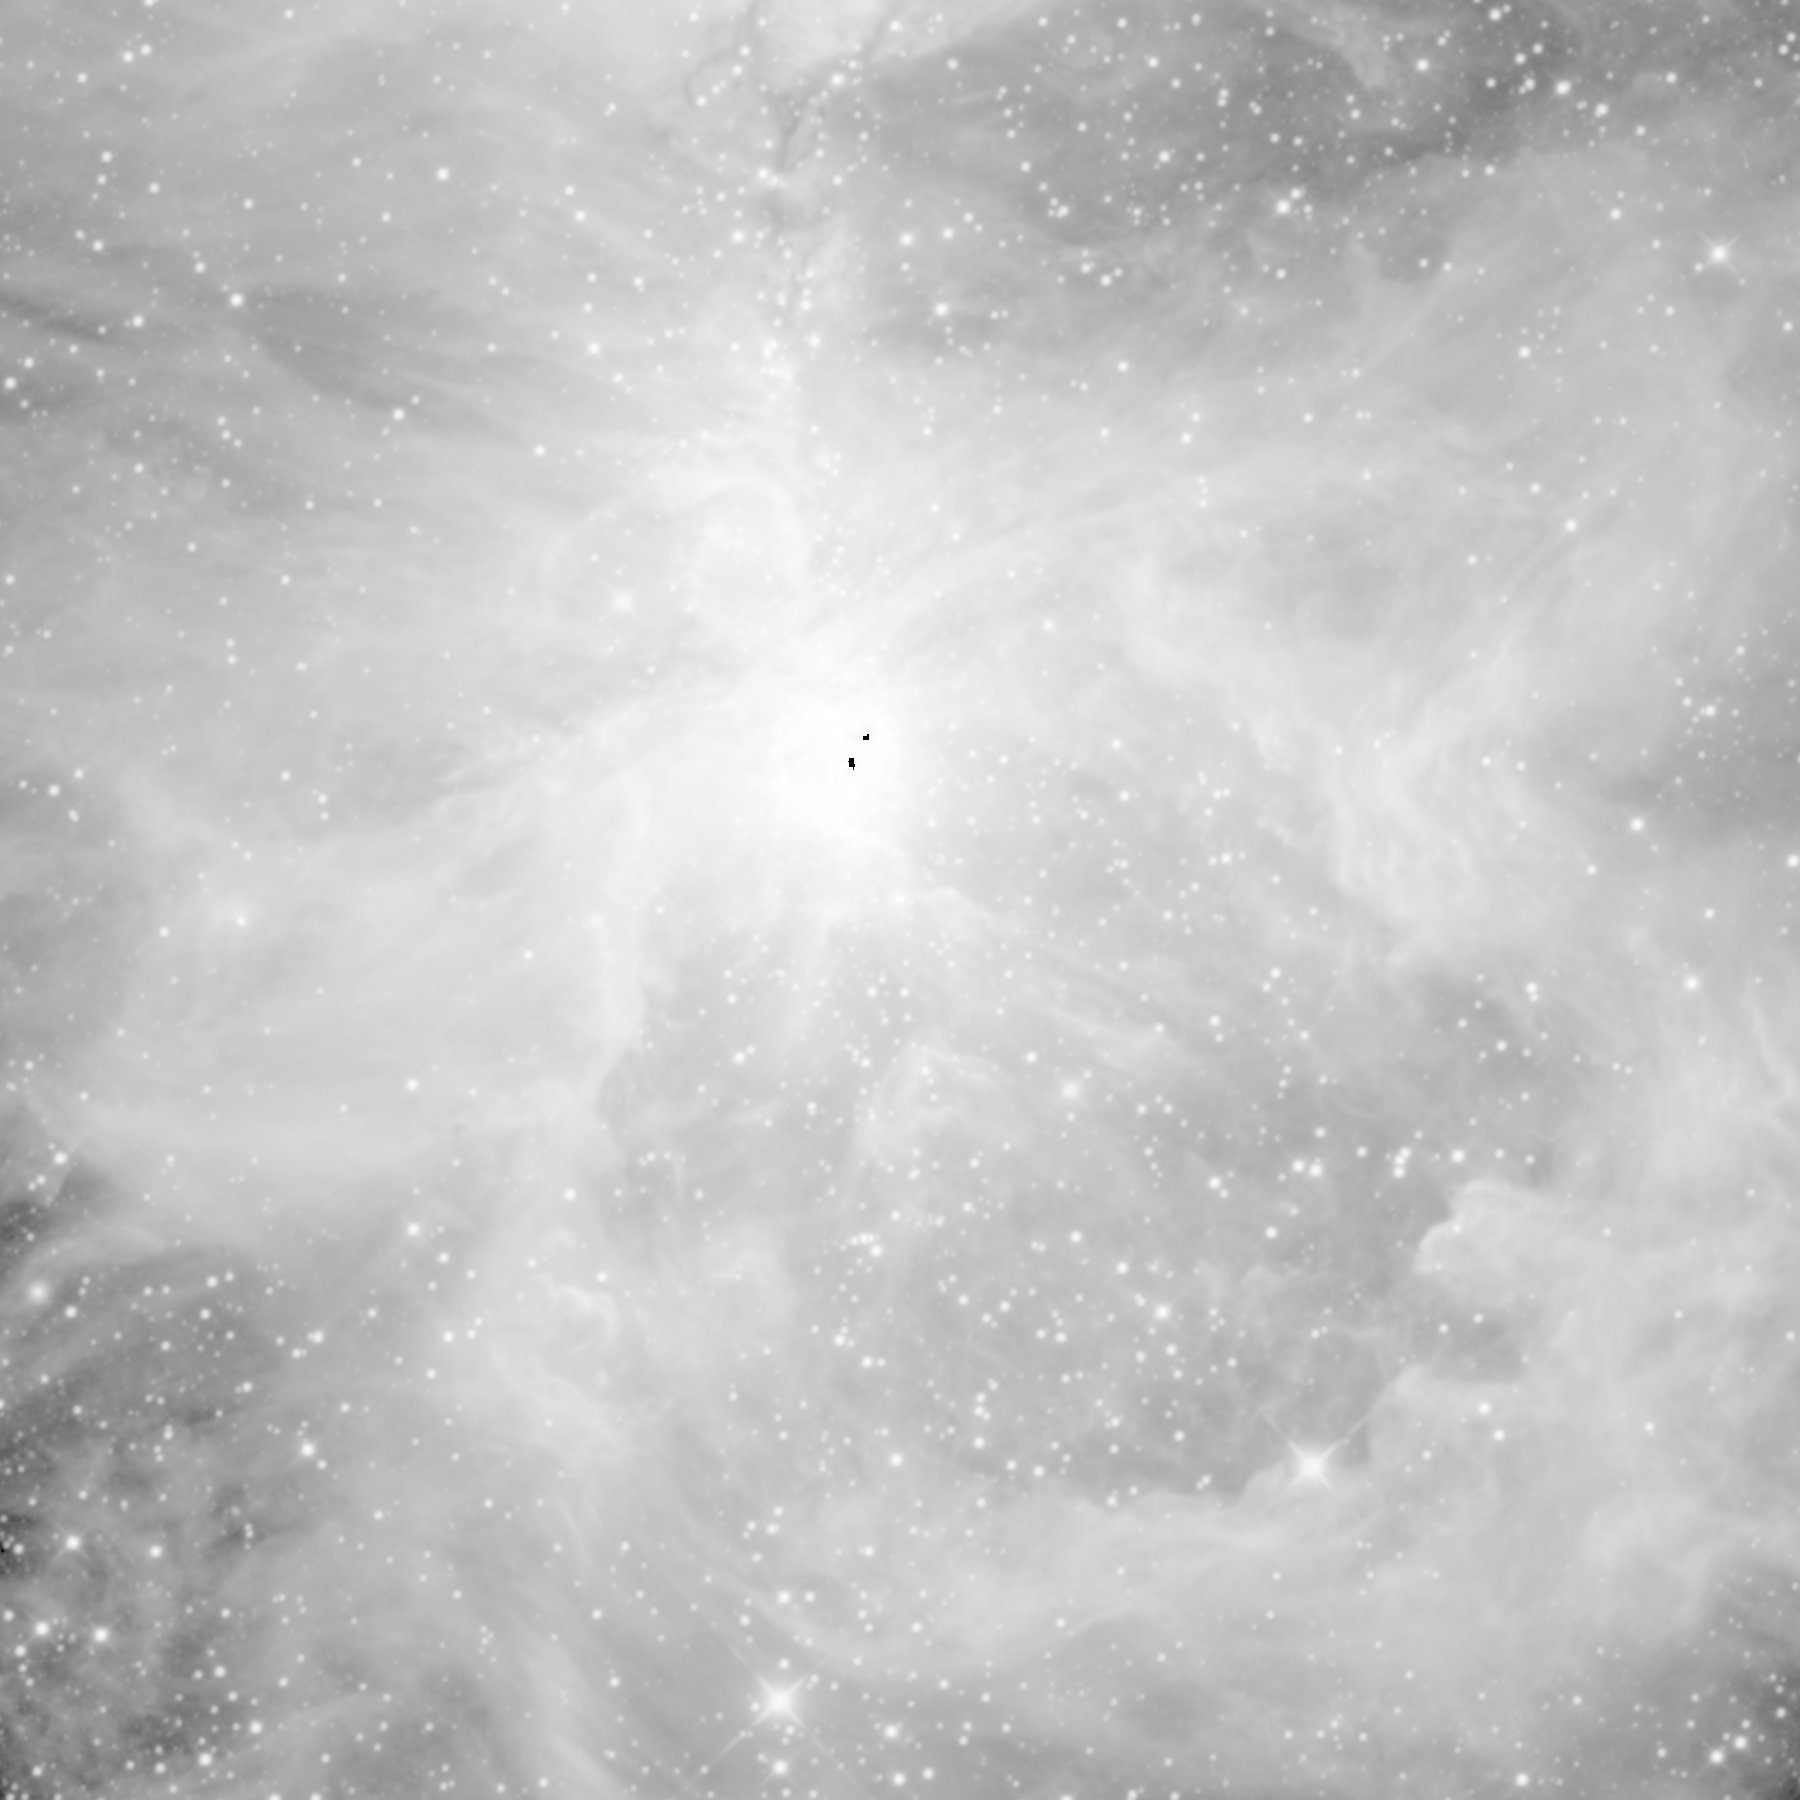

In [18]:
display(Image(jpgfile))

In [19]:
for rowf, band in [0, 'w1'], [2, 'w2'], [4, 'w3'], [6, 'w4']:
    fitsfile = f'data/Orion-VO/lp_ori_wise_{band}.fits'
    r=requests.get(wise_table['URL'][rowf].decode("utf-8"), stream=True)
    with open(fitsfile, 'wb') as f:
        f.write(r.content)
    fits.open(fitsfile).info()

Filename: data/Orion-VO/lp_ori_wise_w1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   (1800, 1800)   float32   
Filename: data/Orion-VO/lp_ori_wise_w2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   (1800, 1800)   float32   
Filename: data/Orion-VO/lp_ori_wise_w3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   (1800, 1800)   float32   
Filename: data/Orion-VO/lp_ori_wise_w4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     129   (1800, 1800)   float32   


Possibly, there is new bow shock over in the east. At `5:36:38.099 -5:28:36.42`

#### And thirdly, try Herschel SPIRE

This is the longer wavelength instrument.  I think that the Herschel PACS data, which includes 70 $\mu$m has to come from IRSA, not from SkyView. 

In [20]:
row = cat_table[cat_table['short_name'] == 'HERSCHEL-SPIRE'.encode()]
description = row[0]['res_description'].decode('utf-8')
url = row[0]['access_url'].decode()
description = html.unescape(html.unescape(html.unescape(description)))
text = f'<div style="background-color:#cde;color:#733;padding:20px;">{description}</div>'
display(HTML(text))

That was short and sweet!

In [21]:
pos = '83.791114,-5.4649843'
pixel_size = 2.0/3600 # 2 arcsec
size = 1.0
N = int(size/pixel_size)
params = {'POS': pos, 'SIZE': f'{size}', "NAXIS": f"{N},{N}"}
r = requests.get(url, params=params)
spire_table=Table.read(io.BytesIO(r.content))
spire_table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object


*Nothing!* Oh well.

In [22]:
row = cat_table[cat_table['short_name'] == 'HAlpha'.encode()]
description = row[0]['res_description'].decode('utf-8')
url = row[0]['access_url'].decode()
description = html.unescape(html.unescape(html.unescape(description)))
text = f'<div style="background-color:#cde;color:#733;padding:20px;">{description}</div>'
display(HTML(text))

In [23]:
pos = '83.791114,-5.4649843'
pixel_size = 180.0/3600 # low res to start with
size = 10.0 # but big field
N = int(size/pixel_size)
params = {'POS': pos, 'SIZE': f'{size}', "NAXIS": f"{N},{N}"}
r = requests.get(url, params=params)
ha_table=Table.read(io.BytesIO(r.content))
ha_table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
halpha,83.791113999999993,-5.4649843000000002,2,[200 200],[-0.05 0.05],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=halpha&pixels=200%2C200&sampler=LI&size=10.0%2C10.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747750446&return=FITS,1
halpha,83.791113999999993,-5.4649843000000002,2,[200 200],[-0.05 0.05],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=83.791114%2C-5.4649843&survey=halpha&pixels=200%2C200&sampler=LI&size=10.0%2C10.0&projection=Tan&coordinates=J2000.0&requestID=skv1539747750446&nofits=1&quicklook=jpeg&return=jpeg,1


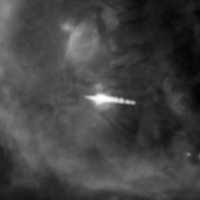

In [24]:
urlretrieve(ha_table['URL'][1].decode("utf-8"), jpgfile)
display(Image(jpgfile))

So that worked, but it is very low resolution.  It shows the sigma orionis region better than M42.

### Getting images from IRSA

This is necessary for the Spitzer and Herschel PACS data

First, find all the catalogs.  ALthough this is not so useful, since I want images not catalogs.

In [25]:
#Start with a Base URL.
tap_base_url = 'https://irsa.ipac.caltech.edu/TAP/sync?'

#Attach search parameters to this.
tap_params = {
    "request": "doQuery",
    "lang": "ADQL",
    "QUERY":"SELECT * FROM TAP_SCHEMA.tables"
    }

#Send the request.
r = requests.post(tap_base_url, data = tap_params)

#Put the results in an astropy table.
table=Table.read(io.BytesIO(r.content))

#Show the table.
table.show_in_notebook()

idx,table_index,schema_name,table_name,table_type,description,utype,irsa_dbms,irsa_pos,cntr
0,517,public,ppsc_extsl,table,PACS Point Source Catalog: Extended Source List,,ORACLE,y,517
1,518,public,ppsc_obstbl,table,PACS Point Source Catalog: Observation Table,,ORACLE,y,518
2,519,public,ppsc_rejsl,table,PACS Point Source Catalog: Rejected Source List,,ORACLE,y,519
3,520,public,spsc250,table,SPIRE Point Source Catalog: 250 microns,,ORACLE,y,520
4,521,public,spsc350,table,SPIRE Point Source Catalog: 350 microns,,ORACLE,y,521
5,522,public,spsc500,table,SPIRE Point Source Catalog: 500 microns,,ORACLE,y,522
6,523,public,spscxid,table,SPIRE Point Source Catalog Cross-Reference Matrix,,ORACLE,n,523
7,524,herschel,herschel.acmc_images,table,Herschel ACMC Image Metadata,,POSTGRES,y,524
8,525,public,acmccat,table,ACMC Catalog,,ORACLE,y,525
9,526,herschel,herschel.coldcores_images,table,Herschel ColdCores Image Metadata,,POSTGRES,y,526


Now, try images.  But how to get a list of possible image types?  List is here: https://irsa.ipac.caltech.edu/ibe/sia.html

In [39]:
#IRSA Simple Image Access Base URL
sia_base_url = 'https://irsa.ipac.caltech.edu/SIA?'
#Parameters of our search
sia_params = {
    "COLLECTION":"wise_allwise",
#    "POS":"circle -164.7 -5.8 0.1",
#    "BAND":"3e-6 4e-6",
#    "COLLECTION":"spitzer_sha",
    'POS': f'circle {pos[0]} {pos[1]} 0.5', 
    }

#Send the Request
r = requests.post(sia_base_url, data = sia_params)

#Put the results in an astropy table.
table=Table.read(io.BytesIO(r.content))

#Show the table.
table.show_in_notebook()

idx,s_region,obs_collection,obs_intent,algorithm_name,facility_name,facility_keywords,instrument_name,instrument_keywords,environment_photometric,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_type,target_standard,target_moving,target_keywords,calib_level,dataproduct_type,s_xel1,s_xel2,position_samplesize,position_timedependent,energy_emband,energy_bandpassname,t_min,t_max,t_exptime,t_resolution,t_xel,access_url,access_format,access_estsize,obs_id,obs_publisher_did,s_ra,s_dec,s_fov,s_resolution,em_min,em_max,em_res_power,em_xel,pol_states,pol_xel,o_ucd
,deg,,,,,,,,,,,,,,,,,,,,,,deg,,,,d,d,s,s,,,,kbyte,,,deg,deg,deg,deg,m,m,,,,,
0,POLYGON ICRS 9.85870918119 2.246168961964 8.293013092472 2.246169237756 8.291881506062 3.810661855114 9.859841320267 3.810661578924 9.85870918119 2.246168961964,wise_allwise,science,mosaic,WISE,,WISE,,--,,Edward L. Wright,WISE,Wide-field Infrared Survey Explorer - AllWISE Atlas Images,,field,False,False,,3,image,4095,4095,2.75,False,Infrared,W1,55376.093045532398,55558.205594085601,180.6497,--,[55376.0930455324 55558.2055940856],https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0090/0090p030_ac51/0090p030_ac51-art-w1-P.tbl,text/plain,--,2e0c9c13-05cb-4f14-9d03-1e1a1eaf03f2,ivo://irsa.ipac/wise_allwise/0090p030_ac51,9.0756700000000006,3.0288889999999999,3.1281249999999998,6.0999999999999996,3.1499999999999999e-06,3.7799999999999998e-06,--,[3.15e-06 3.78e-06],,--,
1,POLYGON ICRS 9.85870918119 2.246168961964 8.293013092472 2.246169237756 8.291881506062 3.810661855114 9.859841320267 3.810661578924 9.85870918119 2.246168961964,wise_allwise,science,mosaic,WISE,,WISE,,--,,Edward L. Wright,WISE,Wide-field Infrared Survey Explorer - AllWISE Atlas Images,,field,False,False,,3,image,4095,4095,2.75,False,Infrared,W1,55376.093045532398,55558.205594085601,180.6497,--,[55376.0930455324 55558.2055940856],https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0090/0090p030_ac51/0090p030_ac51-w1-int-3.fits,image/fits,--,2e0c9c13-05cb-4f14-9d03-1e1a1eaf03f2,ivo://irsa.ipac/wise_allwise/0090p030_ac51,9.0756700000000006,3.0288889999999999,3.1281249999999998,6.0999999999999996,3.1499999999999999e-06,3.7799999999999998e-06,--,[3.15e-06 3.78e-06],,--,
2,POLYGON ICRS 9.85870918119 2.246168961964 8.293013092472 2.246169237756 8.291881506062 3.810661855114 9.859841320267 3.810661578924 9.85870918119 2.246168961964,wise_allwise,science,mosaic,WISE,,WISE,,--,,Edward L. Wright,WISE,Wide-field Infrared Survey Explorer - AllWISE Atlas Images,,field,False,False,,3,image,4095,4095,2.75,False,Infrared,W1,55376.093045532398,55558.205594085601,180.6497,--,[55376.0930455324 55558.2055940856],https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0090/0090p030_ac51/0090p030_ac51-art-w1-H.tbl,text/plain,--,2e0c9c13-05cb-4f14-9d03-1e1a1eaf03f2,ivo://irsa.ipac/wise_allwise/0090p030_ac51,9.0756700000000006,3.0288889999999999,3.1281249999999998,6.0999999999999996,3.1499999999999999e-06,3.7799999999999998e-06,--,[3.15e-06 3.78e-06],,--,
3,POLYGON ICRS 9.85870918119 2.246168961964 8.293013092472 2.246169237756 8.291881506062 3.810661855114 9.859841320267 3.810661578924 9.85870918119 2.246168961964,wise_allwise,science,mosaic,WISE,,WISE,,--,,Edward L. Wright,WISE,Wide-field Infrared Survey Explorer - AllWISE Atlas Images,,field,False,False,,3,image,4095,4095,2.75,False,Infrared,W1,55376.093045532398,55558.205594085601,180.6497,--,[55376.0930455324 55558.2055940856],https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0090/0090p030_ac51/0090p030_ac51-art-w1-D.tbl,text/plain,--,2e0c9c13-05cb-4f14-9d03-1e1a1eaf03f2,ivo://irsa.ipac/wise_allwise/0090p030_ac51,9.0756700000000006,3.0288889999999999,3.1281249999999998,6.0999999999999996,3.1499999999999999e-06,3.7799999999999998e-06,--,[3.15e-06 3.78e-06],,--,
4,POLYGON ICRS 9.85870918119 2.246168961964 8.293013092472 2.246169237756 8.291881506062 3.810661855114 9.859841320267 3.810661578924 9.85870918119 2.246168961964,wise_allwise,sci

In [32]:
pos

'83.791114,-5.4649843'

### Looking for my B star in catalogs

In [26]:
scs_base_url = 'https://irsa.ipac.caltech.edu/SCS?'

scs_params = {'table': 'fp_psc', 'RA': 83.881677, 'DEC': -5.0040292, 'SR':30.0/3600.0}

r = requests.get(scs_base_url, params=scs_params)

table=Table.read(io.BytesIO(r.content))

table.show_in_notebook()

idx,ra,dec,err_maj,err_min,err_ang,designation,j_m,j_msig,j_cmsig,j_msigcom,j_snr,h_m,h_msig,h_cmsig,h_msigcom,h_snr,k_m,k_msig,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,cc_old,ndet,prox,pxpa,pxcntr,gal_contam,mp_flg,cntr,hemis,xdate,scan,id,glon,glat,x,y,z,x_scan,y_scan,jdate,j_m_psf,j_msig_psf,j_psfchi,j_psf_id,h_m_psf,h_msig_psf,h_psfchi,h_psf_id,k_m_psf,k_msig_psf,k_psfchi,k_psf_id,j_skyval,h_skyval,k_skyval,j_skysig,h_skysig,k_skysig,j_blend,h_blend,k_blend,j_peakpix,h_peakpix,k_peakpix,j_m_stdap,j_msig_stdap,h_m_stdap,h_msig_stdap,k_m_stdap,k_msig_stdap,j_m_lgap,j_msig_lgap,h_m_lgap,h_msig_lgap,k_m_lgap,k_msig_lgap,j_m_r1,j_msig_r1,h_m_r1,h_msig_r1,k_m_r1,k_msig_r1,j_cal,h_cal,k_cal,cnf_flg,j_prob_pers,h_prob_pers,k_prob_pers,j_prnt_id,h_prnt_id,k_prnt_id,j_prg_flg,h_prg_flg,k_prg_flg,j_mrg_flg,h_mrg_flg,k_mrg_flg,j_pix_flg,h_pix_flg,k_pix_flg,dist_edge_ns,dist_edge_ew,dist_edge_flg,dup_src,use_src,spos,sdet,a,id_opt,dist_opt,phi_opt,b_m_opt,vr_m_opt,nopt_mchs,ext_key,mp_key,night_key,scan_key,coadd_key,coadd,htm20
,deg,deg,arcs,arcs,deg,,mag,mag,mag,mag,,mag,mag,mag,mag,,mag,mag,mag,mag,,,,,,,,arcs,deg,,,,,,,,,deg,deg,,,,arcs,arcs,jdate,mag,mag,,,mag,mag,,,mag,mag,,,DN,DN,DN,DN,DN,DN,,,,DN,DN,DN,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,arcs,arcs,,,,,,,,arcs,deg,mag,mag,,,,,,,,
0,83.881791,-5.003911,0.06,0.06,90,05353162-0500140,14.778,0.053,0.040,0.041,49.1,11.964,0.043,0.032,0.033,280.7,10.129,0.038,0.019,0.021,1058.8,AAA,222,111,000,000,666666,12.1,144,1194804727,0,0,1194804718,n,2000-11-24,87,5114,208.677,-19.153,0.1061738698520000,0.9905145774210000,-0.0872237426224000,-184.1,-18201.20,2451872.8034,14.778,0.053,1.09,9874,11.964,0.043,1.42,9464,10.129,0.038,1.25,9704,190.35,1120.42,942.73,8.86,12.40,14.08,1,1,1,261.76,1844.39,6667.48,14.707,0.033,11.967,0.038,10.133,0.006,14.113,0.092,11.789,0.035,10.071,0.006,--,--,--,--,10.055,0.041,0.084,0.010,0.054,111111,0.000,0.000,0.000,--,--,--,000,000,000,000000,000000,000101,0066,0066,0066,4113.6000000000004,69.5,se,0,1,1,1,0,,--,--,--,--,0,--,--,1284,64319,1479333,220,9351260902894.0
1,83.883791,-5.006613,0.06,0.06,90,05353210-0500238,15.526,0.059,0.047,0.049,24.7,13.906,0.046,0.036,0.037,46.9,13.143,0.036,0.016,0.018,66.0,AAA,222,111,000,000,565566,12.1,324,1194804718,0,0,1194804727,n,2000-11-24,87,5105,208.680,-19.153,0.1061388559280000,0.9905141919310001,-0.0872707215876000,-191.2,-18210.93,2451872.8034,15.526,0.059,0.99,9874,13.906,0.046,1.10,9464,13.143,0.036,1.17,9704,190.34,1118.99,941.26,8.27,12.51,13.85,1,1,1,105.83,354.23,464.89,15.558,0.098,13.915,0.116,13.269,0.017,15.872,0.416,13.753,0.110,12.940,0.090,--,--,--,--,--,--,0.084,0.010,0.054,111111,0.000,0.000,0.000,--,--,--,000,000,000,000000,000000,000000,0056,0155,0066,4103.8000000000002,62.300000000000004,se,1,1,2,2,0,,--,--,--,--,0,--,--,1284,64319,1479333,220,9351260911718.0
